In [1]:
# Get the data for expeirment
import sklearn
import pandas as pd 
import numpy as np

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import explained_variance_score, mean_squared_error
from scipy.spatial.distance import cdist
from numpy.linalg import pinv
from math import sqrt
import gc
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import geopy.distance as distance
from sklearn.preprocessing import MinMaxScaler

import Data_utils
import matplotlib.ticker as ticker
from functools import reduce
from collections import Counter

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import r2_score

import plotly.express as px
import TsModel
import GprModel
from sklearn.utils import validation
from windrose import WindroseAxes
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.path import Path
from matplotlib.transforms import Affine2D
from matplotlib.patches import Circle, RegularPolygon

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
# Visualization for all models, used in the paper

In [3]:
plt.rcParams.update({'font.size': 18})

In [4]:
train_x = pd.read_csv('Data/exp/1102_no_precp_full_dataset/6x.csv', index_col=0).to_numpy()
train_y = pd.read_csv('Data/exp/1102_no_precp_full_dataset/6y.csv', index_col=0)['0'].to_numpy().reshape(-1, 1)

test_x = pd.read_csv('Data/exp/1102_no_precp_full_dataset/6x_test.csv', index_col=0).to_numpy()
test_y = pd.read_csv('Data/exp/1102_no_precp_full_dataset/6y_test.csv', index_col=0)['0'].to_numpy().reshape(-1, 1)

In [5]:
input_scaler = StandardScaler()
train_x = input_scaler.fit_transform(train_x)
test_x = input_scaler.transform(test_x)

#train_x, train_y = shuffle(train_x, train_y)
#target_scaler = StandardScaler()

# train_y = target_scaler.fit_transform(train_y)
# test_y = target_scaler.fit_transform(test_y)


In [26]:
# Train the TS model
ts_model = TsModel.TsModel(number_of_rules=15, early_end_threshold=1e-8, use_target_in_fcm=False, fuzzification_coefficient=1.1)
ts_model.fit(train_x, train_y)

FCM training RMSE: 5.808757027565221


(33.74165820528834, 5.808757027565221, 115.88103652000427)

In [25]:
preds = ts_model.predict(test_x)

In [22]:
mean_squared_error(preds, test_y, squared=False)

6.1878290462554135

In [8]:
def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [9]:
ts_prototypes = ts_model.cen
ts_qs = ts_model.qs
ts_weights = ts_model.W

In [10]:
ts_weights = ts_weights.reshape(30,37)

In [11]:
ts_prototypes = np.hstack((ts_prototypes, np.zeros((ts_prototypes.shape[0], 1))))

In [23]:
preds = ts_model.predict(ts_prototypes+1e-10)

In [26]:
preds

array([15.37476883, 15.37476884, 15.37476916, 15.37476884, 15.37476882,
       15.37476868, 15.37476898, 15.37476907, 15.37476897, 15.37476857,
       15.37476855, 15.37476887, 15.37476884, 15.37476927, 15.37476883,
       15.3747688 , 15.37476888, 15.37476904, 15.374769  , 15.37476849,
       15.37476858, 15.37476903, 15.37476897, 15.37476872, 15.37476872,
       15.37476882, 15.3747692 , 15.37476876, 15.37476895, 15.37476871])

Text(0.5, 0, 'Prototypes')

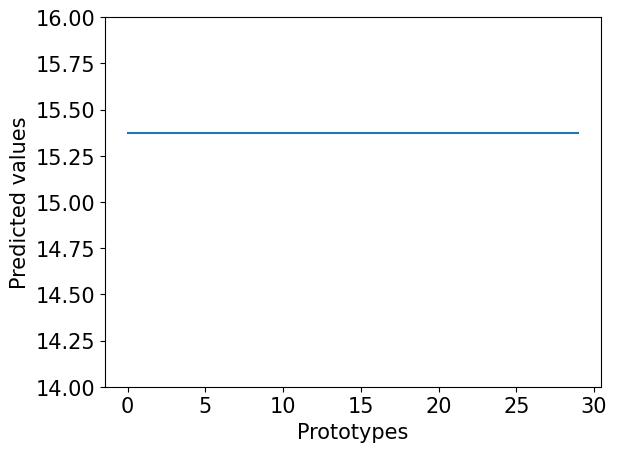

In [31]:
plt.plot(preds)
plt.ylim(14,16)
plt.ylabel('Predicted values')
plt.xlabel('Prototypes')

In [12]:
plt.plot([5, 15, 20, 30, 50], results_q)
plt.ylabel('Optimization target')
plt.xlabel('Number of prototypes')

NameError: name 'results_q' is not defined

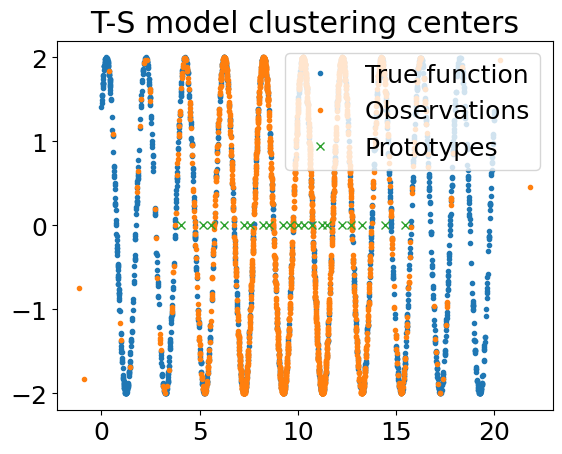

In [82]:
plt.title('T-S model clustering centers')
plt.plot(data[0:,0].reshape(-1,1), data[0:,1].reshape(-1,1),'.', label='True function')
plt.plot(data2[0:,0].reshape(-1,1), data2[0:,1].reshape(-1,1),'.', label='Observations')

plt.plot(ts_prototypes, [0]*len(ts_prototypes), 'x', label='Prototypes')
plt.legend(loc="upper right")

In [14]:
radar_data=[
    [
        'Long1', 'Lat1', 'Temp1', 'Dir1', 'Speed1', 'Dist1',
        'Long2', 'Lat2', 'Temp2', 'Dir2', 'Speed2', 'Dist2',
        'Long3', 'Lat3', 'Temp3', 'Dir3', 'Speed3', 'Dist3',
        'Long4', 'Lat4', 'Temp4', 'Dir4', 'Speed4', 'Dist4',
        'Long5', 'Lat5', 'Temp5', 'Dir5', 'Speed5', 'Dist5',
        'Long6', 'Lat6', 'Temp6', 'Dir6', 'Speed6', 'Dist6',
        'Bias',
    ],
    ('Prototypes',ts_prototypes),
    ('Conclusion parameters',ts_weights)
]

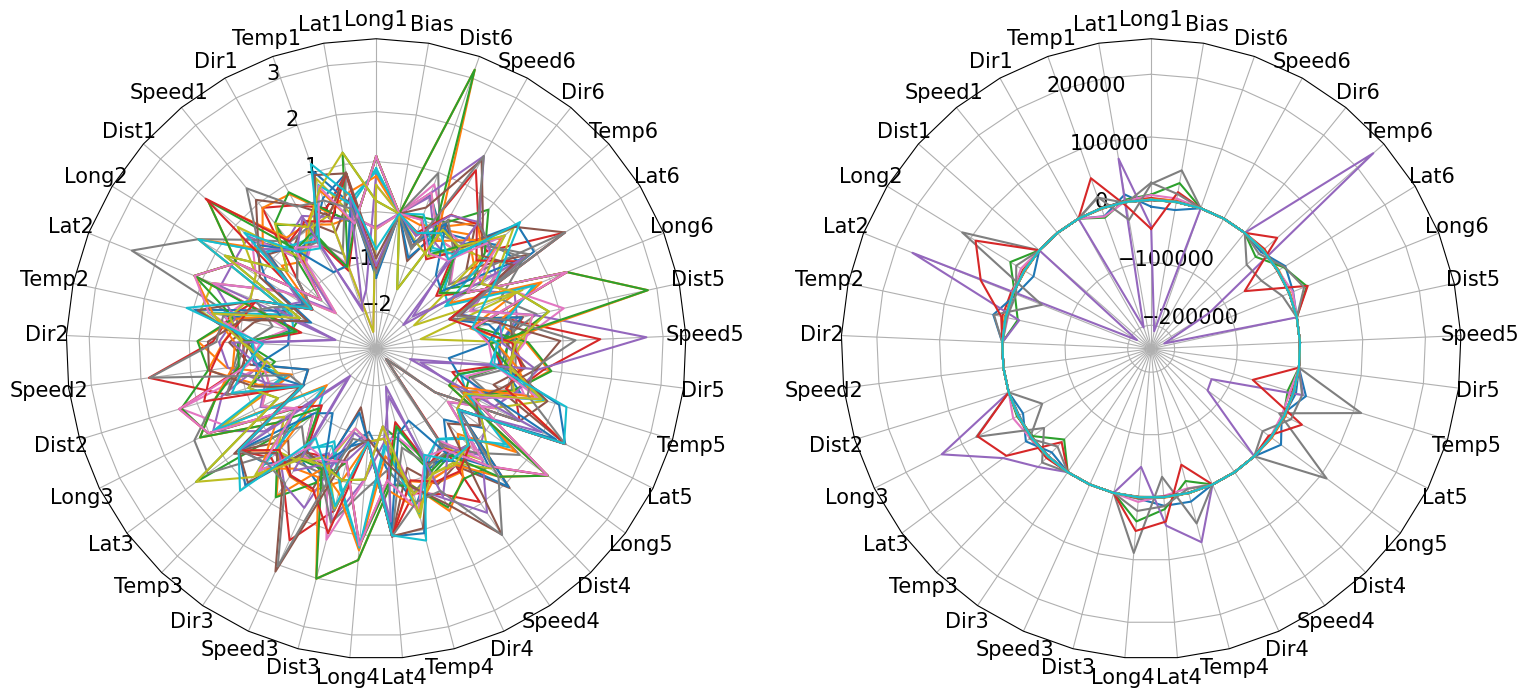

In [15]:
plt.rcParams.update({'font.size': 15})
N = 37
theta = radar_factory(N, frame='polygon')

data = radar_data
spoke_labels = data.pop(0)
#ts_prototypes
fig, axs = plt.subplots(figsize=(18, 9), nrows=1, ncols=2,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

# Plot the four cases from the example data on separate axes
for ax, (title, case_data) in zip(axs.flat, data):
#     ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
#                  horizontalalignment='center', verticalalignment='center')
    for d in case_data:
        ax.plot(theta, d)
        #ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
    ax.set_varlabels(spoke_labels)

# add legend relative to top-left plot
# labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
# legend = axs.legend(labels, loc=(0.9, .95),
#                           labelspacing=0.1, fontsize='small')

# fig.text(0.5, 0.965, 'Visualization of optimial TS rule-based model c=30',
#          horizontalalignment='center', color='black', weight='bold',
#          size='large')

plt.show()

In [4]:
# Modified from source: https://blog.paperspace.com/svr-kmeans-clustering-for-regression/#implementing-k-means-clustering-svr
def kmeans_model(X_train, Y_train, n_clusters=30):
    
    kmeans = KMeans(
    init="random",
    n_clusters=n_clusters,
    max_iter=300)
    
    # Fit to the training data
    kmeans.fit(X_train)
    # Generate out clusters
    train_cluster = kmeans.predict(X_train)
    
    cluster_predictors = []

    for i in range(n_clusters):
        index = np.where(train_cluster == i)[0]
        cluster_X = X_train[index]
        cluster_Y = Y_train[index]
        model = LinearRegression()
        cluster_predictors.append(model.fit(cluster_X, cluster_Y))
    
    return kmeans, cluster_predictors

def regression_function(X_test, kmeans, cluster_svr):
    result = []
    clusters_pred = kmeans.predict(X_test)
    for i,data in enumerate(X_test):
        result.append(((cluster_svr[clusters_pred[i]]).predict([data]))[0])
    return result,clusters_pred

In [67]:
kmeans, k_means_models = kmeans_model(train_x, train_y, n_clusters=30)

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [68]:
result,clusters = regression_function(test_x, kmeans, k_means_models)

In [69]:
mean_squared_error(result, test_y, squared=False)

5.620374563539957

Text(0, 0.5, 'Probability')

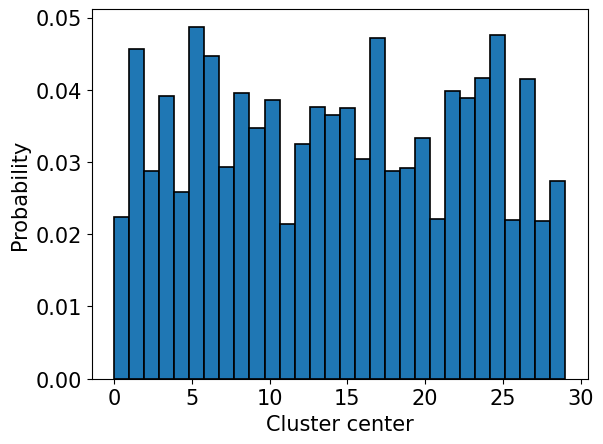

In [82]:
plt.hist(clusters,density=True, bins=30,edgecolor='black', linewidth=1.2)
plt.xlabel('Cluster center')
plt.ylabel('Probability')

In [5]:
# Source: From the TSmodel
def preprocess_data(train, validation):
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train)
    validation_data = scaler.transform(validation)
    
    return train_data, validation_data

In [6]:
# hyperparameters for the expeirment
# This experiment is completed until 10 stations

number_of_neighbour_stations = [1,2,3,4,5,6,7,8,9, 10,11,12]

# Expeirment related parameters
number_of_folds = 10 # have to be 10 fold

# Results containers
training_results = []
test_results = []

# Determine the optimal value for the given hyperparameter
def do_experiment(hyper_parameter_to_test_values):    
    for hyperparameter_value in hyper_parameter_to_test_values:
        # Station data is generated already, only need to train the model
        flatten_train_x = pd.read_csv(f"Data/exp/1102_no_precp_full_dataset/{hyperparameter_value}x.csv", index_col=0).to_numpy()
        flatten_train_y = pd.read_csv(f"Data/exp/1102_no_precp_full_dataset/{hyperparameter_value}y.csv", index_col=0)['0'].to_numpy().reshape(-1, 1)

        # Test data should still need to be generated
        flatten_test_x = pd.read_csv(f"Data/exp/1102_no_precp_full_dataset/{hyperparameter_value}x_test.csv", index_col=0).to_numpy()
        flatten_test_y = pd.read_csv(f"Data/exp/1102_no_precp_full_dataset/{hyperparameter_value}y_test.csv", index_col=0)['0'].to_numpy().reshape(-1, 1)

        # After all data are ready, do a 10 fold cross validation
        training_results_fold = []
        test_results_fold = []
            
        for i in range(0, number_of_folds):
            flatten_train_x, flatten_train_y = shuffle(flatten_train_x, flatten_train_y)
    
            flatten_train_x = np.asarray(flatten_train_x).astype('float32')
            flatten_train_y = np.asarray(flatten_train_y).astype('float32')
            flatten_test_x = np.asarray(flatten_test_x).astype('float32')
            flatten_test_y = np.asarray(flatten_test_y).astype('float32')
            
            print(f"Currently running fold {i} for {hyperparameter_value} stations")

            # Normalize the input
            norm_flatten_train_x, norm_flatten_test_x = preprocess_data(flatten_train_x, flatten_test_x)            
            
            # Kmeans
            kmeans, k_means_models = kmeans_model(flatten_train_x, flatten_train_y, n_clusters=30)
            result,clusters = regression_function(flatten_train_x, kmeans, k_means_models)
            kmeans_train_rmse = mean_squared_error(result, flatten_train_y, squared=False)
            training_results_fold.append({'kmeans_train' : kmeans_train_rmse})
            
            result,clusters = regression_function(flatten_test_x, kmeans, k_means_models)
            kmeans_test_rmse = mean_squared_error(result, flatten_test_y, squared=False)
            test_results_fold.append({'kmeans_test' : kmeans_test_rmse})
        
        #After all folds are done, update the result containers
        training_results.append(training_results_fold)
        test_results.append(test_results_fold)        

In [7]:
do_experiment(number_of_neighbour_stations)

Currently running fold 0 for 1 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 1 for 1 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 2 for 1 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 3 for 1 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 4 for 1 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 5 for 1 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 6 for 1 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 7 for 1 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 8 for 1 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 9 for 1 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 0 for 2 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 1 for 2 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 2 for 2 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 3 for 2 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 4 for 2 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 5 for 2 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 6 for 2 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 7 for 2 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 8 for 2 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 9 for 2 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 0 for 3 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 1 for 3 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 2 for 3 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 3 for 3 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 4 for 3 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 5 for 3 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 6 for 3 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 7 for 3 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 8 for 3 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 9 for 3 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 0 for 4 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 1 for 4 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 2 for 4 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 3 for 4 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 4 for 4 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 5 for 4 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 6 for 4 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 7 for 4 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 8 for 4 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 9 for 4 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 0 for 5 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 1 for 5 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 2 for 5 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 3 for 5 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 4 for 5 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 5 for 5 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 6 for 5 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 7 for 5 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 8 for 5 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 9 for 5 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 0 for 6 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 1 for 6 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 2 for 6 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 3 for 6 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 4 for 6 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 5 for 6 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 6 for 6 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 7 for 6 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 8 for 6 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 9 for 6 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 0 for 7 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 1 for 7 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 2 for 7 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 3 for 7 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 4 for 7 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 5 for 7 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 6 for 7 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 7 for 7 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 8 for 7 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 9 for 7 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 0 for 8 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 1 for 8 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 2 for 8 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 3 for 8 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 4 for 8 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 5 for 8 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 6 for 8 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 7 for 8 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 8 for 8 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 9 for 8 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 0 for 9 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 1 for 9 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 2 for 9 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 3 for 9 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 4 for 9 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 5 for 9 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 6 for 9 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 7 for 9 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 8 for 9 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 9 for 9 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 0 for 10 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 1 for 10 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 2 for 10 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 3 for 10 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 4 for 10 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 5 for 10 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 6 for 10 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 7 for 10 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 8 for 10 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 9 for 10 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 0 for 11 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 1 for 11 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 2 for 11 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 3 for 11 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 4 for 11 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 5 for 11 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 6 for 11 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 7 for 11 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 8 for 11 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 9 for 11 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 0 for 12 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 1 for 12 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 2 for 12 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 3 for 12 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 4 for 12 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 5 for 12 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 6 for 12 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 7 for 12 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 8 for 12 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Currently running fold 9 for 12 stations


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [4]:
# training_results_li_ts_km_nn_full_feature = cleaned_training_results_full_feature
# test_results_li_ts_km_nn_full_feature = cleaned_test_results_full_feature

# %store training_results_li_ts_km_nn_full_feature
# %store test_results_li_ts_km_nn_full_feature

# %store -r training_results_li_ts_km_nn_full_feature
# %store -r test_results_li_ts_km_nn_full_feature

# %store -r training_results_kmeans
# %store -r test_results_kmeans


# %store -r  fcm_opt_training_results
# %store -r  fcm_opt_test_results

In [9]:
training_results_kmeans

[[{'kmeans_train': 6.415967},
  {'kmeans_train': 6.4319706},
  {'kmeans_train': 6.431997},
  {'kmeans_train': 6.438331},
  {'kmeans_train': 6.45694},
  {'kmeans_train': 6.420284},
  {'kmeans_train': 6.4279156},
  {'kmeans_train': 6.42259},
  {'kmeans_train': 6.4316607},
  {'kmeans_train': 6.458555}],
 [{'kmeans_train': 6.009816},
  {'kmeans_train': 5.9990883},
  {'kmeans_train': 6.0155506},
  {'kmeans_train': 5.994141},
  {'kmeans_train': 5.9979305},
  {'kmeans_train': 6.016961},
  {'kmeans_train': 5.99312},
  {'kmeans_train': 6.002393},
  {'kmeans_train': 5.9946957},
  {'kmeans_train': 5.994959}],
 [{'kmeans_train': 5.8056216},
  {'kmeans_train': 5.8174157},
  {'kmeans_train': 5.795318},
  {'kmeans_train': 5.8003726},
  {'kmeans_train': 5.7824564},
  {'kmeans_train': 5.8313656},
  {'kmeans_train': 5.7839837},
  {'kmeans_train': 5.8063087},
  {'kmeans_train': 5.7863903},
  {'kmeans_train': 5.7742114}],
 [{'kmeans_train': 5.708527},
  {'kmeans_train': 5.719775},
  {'kmeans_train': 5.703

In [11]:
training_results_full_feature = np.concatenate((training_results, training_results_kmeans), axis=1)
test_results_full_feature = np.concatenate((test_results, test_results_kmeans), axis=1)

In [39]:
cleaned_training_results_full_feature = []

for exp in training_results_full_feature:
    cleaned_training_results_full_feature.append([d for d in exp if 'fcm_train' not in d])

In [41]:
cleaned_training_results_full_feature = np.concatenate((cleaned_training_results_full_feature, fcm_opt_training_results), axis=1)

In [45]:
cleaned_training_results_full_feature

array([[{'linear_train': 7.231147663276162},
        {'nn_train': 6.237576246261597},
        {'linear_train': 7.231147663276162},
        {'nn_train': 6.2458023357391355},
        {'linear_train': 7.23114766327616},
        {'nn_train': 6.255662145614624},
        {'linear_train': 7.231147663276163},
        {'nn_train': 6.233687028884888},
        {'linear_train': 7.231147663276162},
        {'nn_train': 6.246402711868286},
        {'linear_train': 7.231147663276161},
        {'nn_train': 6.245630121231079},
        {'linear_train': 7.231147663276161},
        {'nn_train': 6.248788843154907},
        {'linear_train': 7.231147663276161},
        {'nn_train': 6.248208236694336},
        {'linear_train': 7.231147663276162},
        {'nn_train': 6.257223634719849},
        {'linear_train': 7.231147663276161},
        {'nn_train': 6.243927421569825}, {'kmeans_train': 6.415967},
        {'kmeans_train': 6.4319706}, {'kmeans_train': 6.431997},
        {'kmeans_train': 6.438331}, {'kmeans_tr

In [46]:
cleaned_test_results_full_feature = []

for exp in test_results_full_feature:
    cleaned_test_results_full_feature.append([d for d in exp if 'fcm_test' not in d])
    
cleaned_test_results_full_feature = np.concatenate((cleaned_test_results_full_feature, fcm_opt_test_results), axis=1)

In [47]:
cleaned_test_results_full_feature

array([[{'linear_test': 7.240682374256583},
        {'nn_test': 6.22400484085083},
        {'linear_test': 7.240682374256583},
        {'nn_test': 6.234264612197876},
        {'linear_test': 7.240682374256583},
        {'nn_test': 6.245461187362671},
        {'linear_test': 7.240682374256581},
        {'nn_test': 6.219100122451782},
        {'linear_test': 7.240682374256583},
        {'nn_test': 6.2356201267242435},
        {'linear_test': 7.240682374256583},
        {'nn_test': 6.234146842956543},
        {'linear_test': 7.240682374256582},
        {'nn_test': 6.238533315658569},
        {'linear_test': 7.240682374256583},
        {'nn_test': 6.2390398597717285},
        {'linear_test': 7.240682374256581},
        {'nn_test': 6.2464713191986085},
        {'linear_test': 7.240682374256583},
        {'nn_test': 6.233240470886231}, {'kmeans_test': 6.4355664},
        {'kmeans_test': 6.4554505}, {'kmeans_test': 6.4607506},
        {'kmeans_test': 6.46352}, {'kmeans_test': 6.479049},
     

exp
linear
7.2311±0.0
nn
6.2463±0.0068
fcm
6.4227±0.0108
kmeans
6.433599948883057±0.01360000018030405
exp
linear
7.0071±0.0
nn
5.8777±0.0068
fcm
5.9567±0.011
kmeans
6.0019001960754395±0.00860000029206276
exp
linear
6.9039±0.0
nn
5.6055±0.0053
fcm
5.6616±0.004
kmeans
5.798299789428711±0.016599999740719795
exp
linear
6.6041±0.0
nn
5.5082±0.0067
fcm
5.5659±0.0081
kmeans
5.706500053405762±0.010599999688565731
exp
linear
6.4277±0.0
nn
5.4781±0.0045
fcm
5.5066±0.0104
kmeans
5.559800148010254±0.009999999776482582
exp
linear
6.4203±0.0
nn
5.4465±0.0047
fcm
5.4596±0.0073
kmeans
5.5177998542785645±0.009999999776482582
exp
linear
6.456±0.0
nn
5.4597±0.0055
fcm
5.4547±0.0116
kmeans
5.4842000007629395±0.006099999882280827
exp
linear
6.5277±0.0
nn
5.446±0.0046
fcm
5.4054±0.004
kmeans
5.46120023727417±0.003700000001117587
exp
linear
6.452±0.0
nn
5.4436±0.0054
fcm
5.3981±0.0069
kmeans
5.449100017547607±0.004699999932199717
exp
linear
6.4835±0.0
nn
5.6134±0.4956
fcm
5.4098±0.0132
kmeans
5.4314999580383

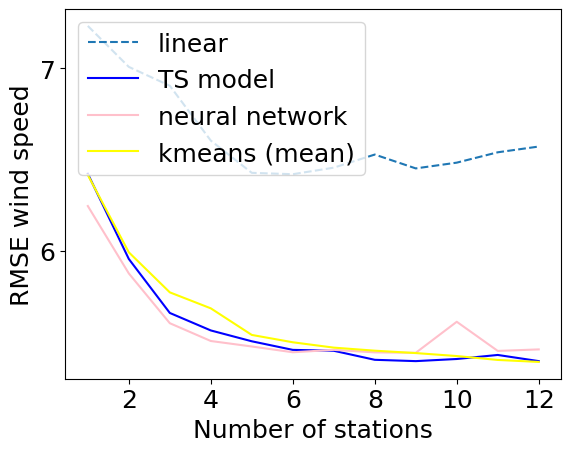

In [6]:
kmeans_train_plot = []
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []

x_axis =  [1,2,3,4,5,6,7,8,9, 10,11,12]
for exp in training_results_li_ts_km_nn_full_feature:
     kmeans_train_plot.append(np.min([d['kmeans_train'] for d in exp if 'kmeans_train' in d]))
     li_train_plot.append(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]))
     fcm_train_plot.append(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]))
     nn_train_plot.append(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]))
    

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
    
plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='TS model', c='blue')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.plot(x_axis, kmeans_train_plot, label='kmeans (mean)', c='yellow')
plt.legend(loc="upper left")
#plt.ylim(5)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind speed')
#plt.title('RMSE wind speed vs number of stations on training data')

for exp in training_results_li_ts_km_nn_full_feature:
    print('exp')
    print('linear')
    print(f"{np.round(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]), 4)}±{np.round(np.std([d['linear_train'] for d in exp if 'linear_train' in d]),4)}")
    
    print('nn')
    print(f"{np.round(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]), 4)}±{np.round(np.std([d['nn_train'] for d in exp if 'nn_train' in d]),4)}")
 
    print('fcm')
    print(f"{np.round(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]), 4)}±{np.round(np.std([d['fcm_train'] for d in exp if 'fcm_train' in d]),4)}")
 
    print('kmeans')
    print(f"{np.round(np.mean([d['kmeans_train'] for d in exp if 'kmeans_train' in d]), 4)}±{np.round(np.std([d['kmeans_train'] for d in exp if 'kmeans_train' in d]),4)}")
 

In [8]:
# gpr_test_results=[]
# gpr_test_results.append({'gpr_test': 124.28245462517742})
# gpr_test_results.append({'gpr_test': 8.098453253845573})
# gpr_test_results.append({'gpr_test': 7.383525517000387})
# gpr_test_results.append({'gpr_test': 7.266723098591452})
# gpr_test_results.append({'gpr_test': 7.269252212307546})
# gpr_test_results.append({'gpr_test': 7.246991937014375})
# gpr_test_results.append({'gpr_test': 7.127975366729728})
# gpr_test_results.append({'gpr_test': 7.125519317911804})
# gpr_test_results.append({'gpr_test': 7.096831995981307})
# gpr_test_results.append({'gpr_test': 7.09245097390881})
# gpr_test_results.append({'gpr_test': 7.123352723065476})
# gpr_test_results.append({'gpr_test': 7.136209476848252})

exp
linear
7.2407±0.0
nn
6.235±0.0081
fcm
6.4338±0.0112
kmeans
6.457499980926514±0.0142000000923872
exp
linear
7.0117±0.0
nn
5.8649±0.0073
fcm
5.9632±0.011
kmeans
79.65010070800781±160.2480926513672
exp
linear
6.916±0.0
nn
5.5969±0.0055
fcm
5.6758±0.0039
kmeans
5.8520002365112305±0.14180000126361847
exp
linear
6.6074±0.0
nn
5.5032±0.0077
fcm
5.5779±0.0082
kmeans
5.712900161743164±0.010499999858438969
exp
linear
6.4329±0.0
nn
5.4698±0.0053
fcm
5.5187±0.0104
kmeans
5.5640997886657715±0.008799999952316284
exp
linear
6.4353±0.0
nn
5.4486±0.0058
fcm
5.4819±0.0063
kmeans
5.530700206756592±0.009499999694526196
exp
linear
6.4589±0.0
nn
5.4641±0.0054
fcm
5.4721±0.0097
kmeans
5.499199867248535±0.005799999926239252
exp
linear
6.5369±0.0
nn
5.4522±0.0037
fcm
5.4277±0.0037
kmeans
5.475500106811523±0.0032999999821186066
exp
linear
6.4553±0.0
nn
5.4465±0.0048
fcm
5.4216±0.0056
kmeans
5.464200019836426±0.0044999998062849045
exp
linear
6.4915±0.0
nn
5.6232±0.5039
fcm
5.4387±0.0116
kmeans
5.451099872589

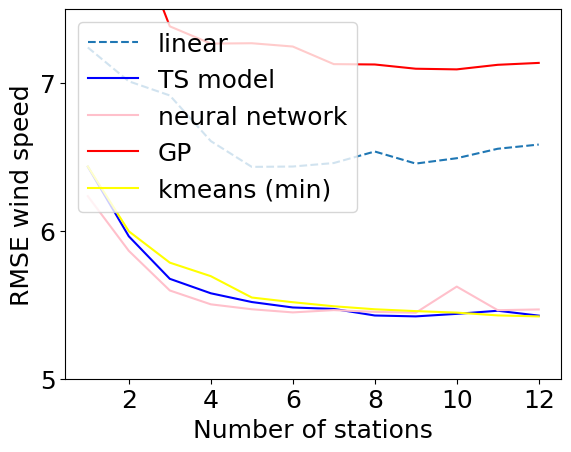

In [9]:
kmeans_train_plot = []
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
gpr_test_plot = []

x_axis =  [1,2,3,4,5,6,7,8,9, 10,11,12]
for exp in test_results_li_ts_km_nn_full_feature:
     kmeans_train_plot.append(np.min([d['kmeans_test'] for d in exp if 'kmeans_test' in d]))
     li_train_plot.append(np.mean([d['linear_test'] for d in exp if 'linear_test' in d]))
     nn_train_plot.append(np.mean([d['nn_test'] for d in exp if 'nn_test' in d]))
     fcm_train_plot.append(np.mean([d['fcm_test'] for d in exp if 'fcm_test' in d]))
for exp in gpr_test_results[0:12]:
    gpr_test_plot.append(exp['gpr_test'])
     

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
    
plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='TS model', c='blue')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.plot(x_axis, gpr_test_plot, label='GP', c='red')
plt.plot(x_axis, kmeans_train_plot, label='kmeans (min)', c='yellow')
plt.legend(loc="upper left")
plt.ylim(5,7.5)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind speed')
#plt.title('RMSE wind speed vs number of stations on training data')

for exp in test_results_li_ts_km_nn_full_feature:
    print('exp')
    print('linear')
    print(f"{np.round(np.mean([d['linear_test'] for d in exp if 'linear_test' in d]), 4)}±{np.round(np.std([d['linear_test'] for d in exp if 'linear_test' in d]),4)}")
    
    print('nn')
    print(f"{np.round(np.mean([d['nn_test'] for d in exp if 'nn_test' in d]), 4)}±{np.round(np.std([d['nn_test'] for d in exp if 'nn_test' in d]),4)}")
 
    print('fcm')
    print(f"{np.round(np.mean([d['fcm_test'] for d in exp if 'fcm_test' in d]), 4)}±{np.round(np.std([d['fcm_test'] for d in exp if 'fcm_test' in d]),4)}")
 
    print('kmeans')
    print(f"{np.round(np.mean([d['kmeans_test'] for d in exp if 'kmeans_test' in d]), 4)}±{np.round(np.std([d['kmeans_test'] for d in exp if 'kmeans_test' in d]),4)}")
 

In [33]:
kmeans_avg = []
for exp in training_results_full_feature:
    kmeans_avg.append(np.mean([d['kmeans_train'] for d in exp if 'kmeans_train' in d]))

print(f"{np.mean(kmeans_avg)}±{np.round(np.std(kmeans_avg),4)}")
 

5.63916540145874±0.29589998722076416


In [31]:
kmeans_avg = []
for exp in test_results_full_feature:
    kmeans_avg.append(np.mean([d['kmeans_test'] for d in exp if 'kmeans_test' in d]))

print(f"{np.mean(kmeans_avg)}±{np.round(np.std(kmeans_avg),4)}")
 

11.793929100036621±20.461299896240234
